# Imports

In [117]:
!pip uninstall deepdowmine -y

Found existing installation: deepdowmine 0.2.3
Uninstalling deepdowmine-0.2.3:
  Successfully uninstalled deepdowmine-0.2.3


In [118]:
!pip install git+https://github.com/dsman1823/deepdowmine.git

  Running command git clone --filter=blob:none --quiet https://github.com/dsman1823/deepdowmine.git 'C:\Users\seidm\AppData\Local\Temp\pip-req-build-41x3go6m'



  Cloning https://github.com/dsman1823/deepdowmine.git to c:\users\seidm\appdata\local\temp\pip-req-build-41x3go6m
  Resolved https://github.com/dsman1823/deepdowmine.git to commit 41051a7f693cc28dc1a8c3d10e6af02b4cc87d2b
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for deepdowmine: filename=deepdowmine-0.2.3-py3-none-any.whl size=58140 sha256=8548b99c452ee40c895dd9871f06b81be2fe8bd90430bda29ab289773277b9d5
  Stored in directory: C:\Users\seidm\AppData\Local\Temp\pip-ephem-wheel-cache-jq_rcv78\wheels\34\6a\e2\d811ae5001e9041d5979f0c60b3e7fe66582099e9e229bead2
Successfully built deepdowmine


In [119]:
from deepdowmine.layers import CovarianceMatrix
from deepdowmine.layers.allocate import NumericalMarkowitzWithShorting
import torch
import torch.nn.functional as F

In [120]:
from deepdowmine.benchmarks import Benchmark, OneOverN, Random
from deepdowmine.callbacks import EarlyStoppingCallback
from deepdowmine.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale, SeqRigidDataLoader, WeeklyRigidDataLoader
from deepdowmine.data.synthetic import sin_single
from deepdowmine.experiments import Run
from deepdowmine.layers import SoftmaxAllocator
from deepdowmine.losses import MeanReturns, SharpeRatio, MaximumDrawdown, StandardDeviation
from deepdowmine.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from deepdowmine.nn import BachelierNetWithShorting, BachelierNet, KeynesNet, BachelierNetWithShortingUpd, LinearNetMine
from deepdowmine.nn import RnnNetFullOpti, LstmNetFullOpti, DenseNetMinVar, DenseNetFullOpti, ConvNetFullOpti


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


# Setup

In [121]:
np.random.seed(5)
returns = pd.read_csv('old_train_data_0.csv', index_col = 0).to_numpy()[1:]

In [122]:
len(returns)

2757

In [123]:
n_timesteps, n_assets = len(returns), 5#11**4, 450

#returns = np.random.normal(0, .2, size = (n_timesteps, n_assets))

lookback, gap, horizon = 50, 0, 5# 40, 0, 5   loss=-0.09645, test_loss=-0.08003]
n_samples = n_timesteps - lookback - horizon - gap + 1

indices = np.arange(n_samples)
# np.random.seed(32)
# np.random.shuffle(indices)
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

# Split the indices array into training and test sets
split_ix = int(n_samples * 0.9)
indices_train = indices[:split_ix]
indices_test = indices[split_ix:]


# print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
#                                                      indices_test[0], indices_test[-1]))

In [124]:
def transform_returns_to_Xy_tensors(returns, lookback, n_timesteps, horizon, gap):
    X_list, y_list = [], []

    for i in range(lookback, n_timesteps - horizon - gap + 1):
        X_list.append(returns[i - lookback: i, :])
        y_list.append(returns[i + gap: i + gap + horizon, :])

    X = np.stack(X_list, axis=0)[:, None, ...]
    y = np.stack(y_list, axis=0)[:, None, ...]

    return X, y

In [125]:

#returns = np.random.normal(0, .2, size = (n_timesteps, n_assets))

# X_list, y_list = [], []

# for i in range(lookback, n_timesteps - horizon - gap + 1):
#     X_list.append(returns[i - lookback: i, :])
#     y_list.append(returns[i + gap: i + gap + horizon, :])

# X = np.stack(X_list, axis=0)[:, None, ...]
# y = np.stack(y_list, axis=0)[:, None, ...]
X, y = transform_returns_to_Xy_tensors(returns, lookback, n_timesteps, horizon, gap)
#print('X: {}, y: {}'.format(X.shape, y.shape))

# means, stds = prepare_standard_scaler(X, indices=indices_train)
# print('mean: {}, std: {}'.format(means, stds))

dataset = InRAMDataset(X, y)
#, transform=Scale(means, stds))
dataloader_train = RigidDataLoader(dataset,
                                   indices=indices_train,
                                   batch_size=32)

dataloader_test = RigidDataLoader(dataset,
                                  indices=indices_test,
                                  batch_size=32)



# Network setup

In [126]:
from deepdowmine.losses import SharpeRatio

In [127]:
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
import torch
from torch.distributions import MultivariateNormal
import torch.nn as nn
import torch.nn.init as init
from deepdowmine.layers.misc import Cov2Corr, CovarianceMatrix, KMeans
# from deepdowmine.layers.transform import Cov
import deepdowmine.layers.transform as ddt

from deepdowmine.nn import UpdNumericalMarkowitzWithShorting, MinVarWithShorting, BachelierNetWithShortingUpd
from deepdowmine.layers import RNN, AttentionCollapse, AverageCollapse
import torch.nn.functional as F

In [128]:
n_samples, n_input_channels, lookback, n_assets = 32, 1, 50, 5
n_output_channels = 8
x = torch.rand(n_samples, n_input_channels, lookback, n_assets)
layer = nn.RNN(5, 8)

In [129]:
#tmp['conv_res'].shape

In [130]:
from deepdowmine.nn import RnnNetMinVar, LstmNetMinVar

In [131]:
network = ConvNetFullOpti(1, 50, 5, .2)
print(network)
network = network.train()
loss = SharpeRatio()
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={
              'test': dataloader_test,
              'train': dataloader_train
              },
          optimizer=torch.optim.Adam(network.parameters(), amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss',
                                           dataloader_name='test',
                                           patience=15)]) #15 # patience controlls amount offffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffrfvd

ConvNetFullOpti(
  (norm_layer): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_layer): Conv2d(1, 2, kernel_size=(3, 1), stride=(2, 1))
  (covariance_layer): CovarianceMatrix()
  (linear): Linear(in_features=120, out_features=5, bias=True)
  (linear_cov): Linear(in_features=120, out_features=100, bias=True)
  (portfolio_opt_layer): UpdNumericalMarkowitzWithShorting(
    (cvxpylayer): CvxpyLayer()
  )
)


# Train start

In [132]:
history = run.launch(450)
torch.save(network.state_dict(), 'network_2.pth')


Epoch 0:   0%|                                                                                  | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 0:  41%|███████████████████████▋                                  | 31/76 [00:14<00:20,  2.20it/s, loss=-0.01943]


Epoch 0:  84%|████████████████████████████████████████████████▊         | 64/76 [00:27<00:04,  2.46it/s, loss=-0.03120]


Epoch 0: 100%|█████████████████| 76/76 [00:58<00:00,  1.31it/s, loss=-0.02884, test_loss=-0.14254, train_loss=-0.03612]

Epoch 1:   0%|                                                                                  | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 1:  22%|████████████▉                                             | 17/76 [00:08<00:26,  2.22it/s, loss=-0.04236]


Epoch 1:  66%|██████████████████████████████████████▏                   | 50/76 [00:22<00:11,  2.36it/s, loss=-0.04023]


Epoch 1: 100%|█████████████████| 76/76 [01:03<00:00,  1.21it/s, loss=-0.04411, test_loss=-0.14436, train_loss=-0.05185]

Epoch 2:   0%|                                                                                  | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 2:   5%|███                                                        | 4/76 [00:01<00:32,  2.23it/s, loss=-0.03588]


Epoch 2:  49%|████████████████████████████▏                             | 37/76 [00:15<00:16,  2.37it/s, loss=-0.03729]


Epoch 2:  92%|█████████████████████████████████████████████████████▍    | 70/76 [00:30<00:02,  2.09it/s, loss=-0.04713]


Epoch 2: 100%|█████████████████| 76/76 [01:05<00:00,  1.17it/s, loss=-0.05104, test_loss=-0.14436, train_loss=-0.05045]

Epoch 3:   0%|                                                                                  | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 3:  30%|█████████████████▌                                        | 23/76 [00:09<00:21,  2.45it/s, loss=-0.02894]


Epoch 3:  74%|██████████████████████████████████████████▋               | 56/76 [00:23<00:08,  2.36it/s, loss=-0.05115]


Epoch 3: 100%|█████████████████| 76/76 [01:00<00:00,  1.25it/s, loss=-0.05270, test_loss=-0.14436, train_loss=-0.05350]

Epoch 4:   0%|                                                                                  | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 4:  13%|███████▋                                                  | 10/76 [00:04<00:27,  2.42it/s, loss=-0.07707]


Epoch 4:  57%|████████████████████████████████▊                         | 43/76 [00:18<00:13,  2.40it/s, loss=-0.06001]


Epoch 4: 100%|██████████████████████████████████████████████████████████| 76/76 [00:32<00:00,  2.41it/s, loss=-0.05281]


Epoch 4: 100%|█████████████████| 76/76 [01:01<00:00,  1.23it/s, loss=-0.05426, test_loss=-0.14436, train_loss=-0.05638]

Epoch 5:   0%|                                                                                  | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 5:  38%|██████████████████████▏                                   | 29/76 [00:13<00:19,  2.38it/s, loss=-0.07704]


Epoch 5:  82%|███████████████████████████████████████████████▎          | 62/76 [00:26<00:06,  2.31it/s, loss=-0.05117]


Epoch 5: 100%|█████████████████| 76/76 [00:58<00:00,  1.30it/s, loss=-0.05817, test_loss=-0.14436, train_loss=-0.05863]

Epoch 6:   0%|                                                                                  | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 6:  21%|████████████▏                                             | 16/76 [00:07<00:28,  2.14it/s, loss=-0.07671]


Epoch 6:  64%|█████████████████████████████████████▍                    | 49/76 [00:21<00:12,  2.19it/s, loss=-0.05527]


Epoch 6: 100%|█████████████████| 76/76 [01:02<00:00,  1.21it/s, loss=-0.05969, test_loss=-0.14436, train_loss=-0.06024]

Epoch 7:   0%|                                                                                  | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 7:   3%|█▌                                                         | 2/76 [00:01<00:56,  1.31it/s, loss=-0.01792]


Epoch 7:  46%|██████████████████████████▋                               | 35/76 [00:33<00:40,  1.00it/s, loss=-0.08179]


Epoch 7:  89%|███████████████████████████████████████████████████▉      | 68/76 [00:56<00:05,  1.39it/s, loss=-0.07288]


Epoch 7: 100%|█████████████████| 76/76 [01:43<00:00,  1.36s/it, loss=-0.06331, test_loss=-0.14507, train_loss=-0.06030]

Epoch 8:   0%|                                                                                  | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 8:  29%|████████████████▊                                         | 22/76 [00:14<00:33,  1.61it/s, loss=-0.01079]


Epoch 8:  72%|█████████████████████████████████████████▉                | 55/76 [00:45<00:11,  1.77it/s, loss=-0.05598]


Epoch 8: 100%|█████████████████| 76/76 [01:49<00:00,  1.44s/it, loss=-0.06104, test_loss=-0.14436, train_loss=-0.06892]

Epoch 9:   0%|                                                                                  | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 9:  11%|██████▏                                                    | 8/76 [00:05<00:45,  1.50it/s, loss=-0.11582]


Epoch 9:  54%|███████████████████████████████▎                          | 41/76 [00:33<00:35,  1.02s/it, loss=-0.07361]


Epoch 9:  97%|████████████████████████████████████████████████████████▍ | 74/76 [01:20<00:01,  1.25it/s, loss=-0.07008]


Epoch 9: 100%|█████████████████| 76/76 [02:28<00:00,  1.95s/it, loss=-0.06995, test_loss=-0.14448, train_loss=-0.07332]

Epoch 10:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 10:  37%|█████████████████████                                    | 28/76 [00:22<00:33,  1.44it/s, loss=-0.06174]


Epoch 10:  80%|█████████████████████████████████████████████▊           | 61/76 [00:47<00:10,  1.46it/s, loss=-0.06753]


Epoch 10: 100%|████████████████| 76/76 [01:41<00:00,  1.34s/it, loss=-0.07576, test_loss=-0.11398, train_loss=-0.08133]

Epoch 11:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 11:  18%|██████████▌                                              | 14/76 [00:09<00:43,  1.41it/s, loss=-0.15281]


Epoch 11:  62%|███████████████████████████████████▎                     | 47/76 [00:32<00:19,  1.47it/s, loss=-0.08550]


Epoch 11: 100%|████████████████| 76/76 [01:31<00:00,  1.20s/it, loss=-0.07967, test_loss=-0.12070, train_loss=-0.09137]

Epoch 12:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 12:   1%|▉                                                                        | 1/76 [00:00<01:01,  1.21it/s]


Epoch 12:  45%|█████████████████████████▌                               | 34/76 [00:24<00:27,  1.53it/s, loss=-0.05915]


Epoch 12:  88%|██████████████████████████████████████████████████▎      | 67/76 [00:46<00:05,  1.52it/s, loss=-0.08391]


Epoch 12: 100%|████████████████| 76/76 [01:34<00:00,  1.24s/it, loss=-0.08334, test_loss=-0.12811, train_loss=-0.10380]

Epoch 13:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 13:  26%|███████████████                                          | 20/76 [00:14<00:41,  1.36it/s, loss=-0.12723]


Epoch 13:  70%|███████████████████████████████████████▊                 | 53/76 [00:39<00:17,  1.29it/s, loss=-0.08739]


Epoch 13: 100%|████████████████| 76/76 [01:33<00:00,  1.23s/it, loss=-0.09868, test_loss=-0.12872, train_loss=-0.10926]

Epoch 14:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 14:   9%|█████▎                                                    | 7/76 [00:05<00:51,  1.33it/s, loss=-0.17325]


Epoch 14:  53%|██████████████████████████████                           | 40/76 [00:30<00:24,  1.49it/s, loss=-0.13049]


Epoch 14:  96%|██████████████████████████████████████████████████████▊  | 73/76 [00:54<00:02,  1.49it/s, loss=-0.11129]


Epoch 14: 100%|████████████████| 76/76 [01:42<00:00,  1.34s/it, loss=-0.11337, test_loss=-0.13318, train_loss=-0.13150]

Epoch 15:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 15:  34%|███████████████████▌                                     | 26/76 [00:23<00:48,  1.03it/s, loss=-0.13972]


Epoch 15:  78%|████████████████████████████████████████████▎            | 59/76 [00:55<00:15,  1.07it/s, loss=-0.12581]


Epoch 15: 100%|████████████████| 76/76 [02:04<00:00,  1.64s/it, loss=-0.11926, test_loss=-0.13087, train_loss=-0.13316]

Epoch 16:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 16:  17%|█████████▊                                               | 13/76 [00:10<00:51,  1.22it/s, loss=-0.15413]


Epoch 16:  61%|██████████████████████████████████▌                      | 46/76 [00:38<00:26,  1.12it/s, loss=-0.14644]


Epoch 16: 100%|████████████████| 76/76 [01:55<00:00,  1.52s/it, loss=-0.14411, test_loss=-0.12635, train_loss=-0.16303]

Epoch 17:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)



Epoch 17:  43%|████████████████████████▊                                | 33/76 [00:31<00:40,  1.06it/s, loss=-0.16163]


Epoch 17:  87%|█████████████████████████████████████████████████▌       | 66/76 [00:56<00:07,  1.40it/s, loss=-0.15294]


Epoch 17: 100%|████████████████| 76/76 [01:37<00:00,  1.29s/it, loss=-0.15575, test_loss=-0.11785, train_loss=-0.17958]

Epoch 18:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 18:  26%|███████████████                                          | 20/76 [00:12<00:34,  1.63it/s, loss=-0.14845]


Epoch 18:  70%|███████████████████████████████████████▊                 | 53/76 [00:32<00:13,  1.64it/s, loss=-0.17165]


Epoch 18: 100%|████████████████| 76/76 [01:22<00:00,  1.08s/it, loss=-0.16539, test_loss=-0.11636, train_loss=-0.19144]

Epoch 19:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 19:   8%|████▌                                                     | 6/76 [00:03<00:43,  1.62it/s, loss=-0.18636]


Epoch 19:  51%|█████████████████████████████▎                           | 39/76 [00:25<00:18,  1.97it/s, loss=-0.20494]


Epoch 19:  95%|██████████████████████████████████████████████████████   | 72/76 [00:45<00:03,  1.16it/s, loss=-0.18458]


Epoch 19: 100%|████████████████| 76/76 [01:18<00:00,  1.04s/it, loss=-0.18315, test_loss=-0.14061, train_loss=-0.20964]

Epoch 20:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 20:  34%|███████████████████▌                                     | 26/76 [00:14<00:27,  1.84it/s, loss=-0.19398]


Epoch 20:  78%|████████████████████████████████████████████▎            | 59/76 [00:35<00:09,  1.70it/s, loss=-0.20090]


Epoch 20: 100%|████████████████| 76/76 [01:16<00:00,  1.01s/it, loss=-0.20246, test_loss=-0.11917, train_loss=-0.23039]

Epoch 21:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)

Epoch 21:  16%|█████████                                                | 12/76 [00:07<00:40,  1.57it/s, loss=-0.26488]


Epoch 21:  59%|█████████████████████████████████▊                       | 45/76 [00:26<00:18,  1.70it/s, loss=-0.22842]


Epoch 21: 100%|████████████████| 76/76 [01:18<00:00,  1.03s/it, loss=-0.20727, test_loss=-0.11336, train_loss=-0.24175]

Epoch 22:   0%|                                                                                 | 0/76 [00:00<?, ?it/s]C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)



Epoch 22:  43%|████████████████████████▊                                | 33/76 [00:20<00:27,  1.56it/s, loss=-0.22661]


Epoch 22:  87%|█████████████████████████████████████████████████▌       | 66/76 [00:41<00:06,  1.66it/s, loss=-0.22389]


Epoch 22: 100%|████████████████| 76/76 [01:22<00:00,  1.08s/it, loss=-0.22381, test_loss=-0.12041, train_loss=-0.25036]


Training interrupted
Training stopped early because there was no improvement in test_loss for 15 epochs


# Check model perfomance

In [18]:
  network = LstmNetMinVar(5)
  network.load_state_dict(torch.load(fr'network_2.pth'))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

In [133]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

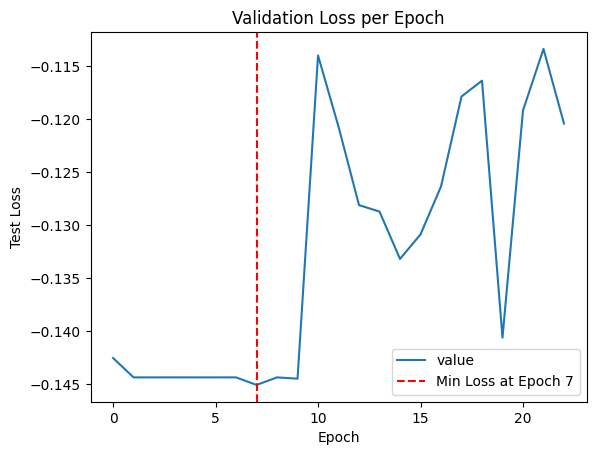

In [134]:
mean_test_loss = per_epoch_results.mean()['test']['loss']['network'] # tmp

# Plotting the mean test loss per epoch
mean_test_loss.plot()

# Finding the epoch with the minimum test loss
min_loss_epoch = mean_test_loss.idxmin()
min_loss_value = mean_test_loss.min()

# Adding a red vertical line at the epoch with minimum test loss
plt.axvline(x=min_loss_epoch, color='r', linestyle='--', label=f'Min Loss at Epoch {min_loss_epoch}')

# Adding some labels and title for clarity
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Validation Loss per Epoch')
plt.legend()

# Show the plot
plt.show()

In [135]:
per_epoch_results.mean()['test']['loss']['network'].mean()

-0.13270974

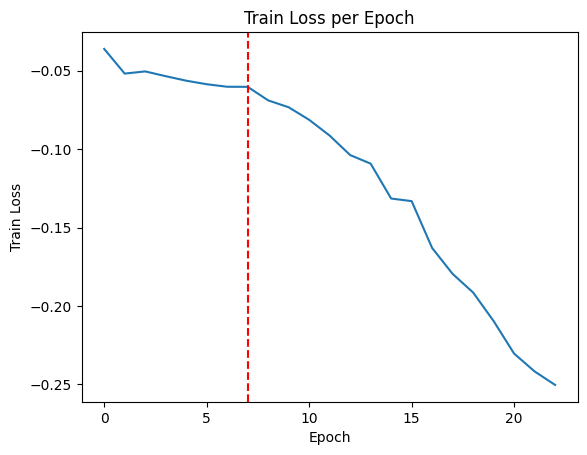

In [136]:
mean_train_loss = per_epoch_results.mean()['train']['loss']['network']

# Plotting the mean test loss per epoch
mean_train_loss.plot()



# Adding some labels and title for clarity
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss per Epoch')
plt.axvline(x=min_loss_epoch, color='r', linestyle='--', label=f'The best model {min_loss_epoch}')

# Show the plot
plt.show()

In [137]:
from deepdowmine.benchmarks import Benchmark, OneOverN, Random

benchmarks = {
    '1overN': OneOverN(),  # each asset has weight 1 / n_assets
    'network': network
}

metrics = {
    'Sharpe': SharpeRatio(),
}


metrics_table = generate_metrics_table(benchmarks,
                                       dataloader_test,
                                       metrics
)

C:\Users\seidm\miniconda3\envs\ddow\lib\site-packages\threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [138]:
metrics_table[metrics_table['benchmark'] == 'network']['value'].mean() / metrics_table[metrics_table['benchmark'] == '1overN']['value'].mean()

0.7830801

In [98]:
metrics_table[metrics_table['benchmark'] == '1overN']['value'].mean()

-0.22060323

In [79]:
metrics_table[metrics_table['benchmark'] == 'network']['value'].mean()

-0.1613177

In [ ]:
len(indices_test)

346

In [ ]:
one_over_n = metrics_table[metrics_table['benchmark'] == '1overN']['value']

In [ ]:
np.array(one_over_n)[indices_test]

IndexError: index 3111 is out of bounds for axis 0 with size 346

In [ ]:
# Filter the DataFrame for the two conditions
one_over_n = -metrics_table[metrics_table['benchmark'] == '1overN']['value']
network_res = -metrics_table[metrics_table['benchmark'] == 'network']['value']


x_axis = np.arange(len(one_over_n))  # This will create an array [0, 1, ..., n-1]

plt.figure(figsize=(10, 6))

# Plot each series on the same plot
plt.plot(x_axis, one_over_n, label='1overN', marker='o', linestyle='-')
plt.plot(x_axis, network_res, label='Network', marker='x', linestyle='-')

# Adding titles and labels
plt.title('Sharpe Ratio Comparison')
plt.xlabel('Index')
plt.ylabel('Sharpe Ratio')

# Show legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
network_res

NameError: name 'network_res' is not defined

In [ ]:
metrics_table[metrics_table['benchmark'] == 'network']['value'].mean()

# Load the results

In [ ]:
network = LinearNetMine(1, lookback, n_assets, p=0.5)
network.load_state_dict(torch.load('linear_net_50x5_sharpe.pth'))

# Supplementary code

In [ ]:
# 1.363

In [ ]:
X.shape

In [ ]:
test_X = torch.tensor(X[[-1]], dtype=torch.float32)#(X[indices_train], dtype=torch.float32) #indices_train
test_X.shape

In [ ]:
def get_activation(name):
    # This function will return a hook function that stores the output in a dictionary
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Attach the hook to the covariance_layer, which precedes the channel_collapse_layer
activations = {}
hook = network.portfolio_opt_layer.register_forward_hook(get_activation('portfolio_opt_layer'))

# Now run your data through the network. This will store the output of the covariance_layer in activations
network(test_X)

# The output you're interested in is now stored in activations['covariance_layer_output']
input_to_channel_collapse = activations['portfolio_opt_layer']

# Don't forget to remove the hook when you're done to prevent memory leaks
hook.remove()

In [ ]:
input_to_channel_collapse.shape

In [ ]:
network(test_X).shape